# Inverse design with Bayesian Optimization (BO)

贝叶斯优化是一种黑盒优化算法，用于求解表达式未知的函数的极值问题。 算法根据一组采样点处的函数值预测出任意点处函数值的概率分布，这通过高斯过程回归（GPR）而实现。 根据GPR的结果构造采集函数，用于衡量每一个点值得探索的程度，求解采集函数的极值从而确定下一个采样点。

在本任务中，我们希望通过贝叶斯优化去以迭代的形式采样组分空间，以使得最终获得的组分向量对应的性质向量与给定性质向量尽可能接近。算法中采用的目标函数即给定的性质向量以及使用另一个GP回归模型对采样的组分向量进行预测所得的性质向量的均方差MSE，而贝叶斯优化模型将尝试去最小化这个均方差。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from scipy.special import softmax # used for composition constraint

## Dataset, scale, split & GPR fitting

In [2]:
toy_alloy_data = pd.read_csv("../Mercury/data/toydata_clean.csv")

X_col = [f'element {i}' for i in range(1,13)]
Y_col = [f'property {i}' for i in range(1,7)]

X = toy_alloy_data[X_col].values
Y = toy_alloy_data[Y_col].values

# scale Y
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [3]:
# Bounded region of parameter space
pbounds = {f'element{num:02d}': (0, 1) for num in range(1,13)}

In [4]:
def dict2array(next_point_dict):
    return np.array([[next_point_dict[f'element{num:02d}'] for num in range(1,13)]])

In [5]:
def inverse_BO(Y_given):

    # Use a GPR as the regressor to predict the property given a probing composition
    gpr = GaussianProcessRegressor(alpha=1, normalize_y=True)
    gpr.fit(X_train, Y_train)

    # objective function for BO
    def diff_property(next_point_array, Y_given, regressor, scaler=scaler):

        """
        Given a probing composition vector (next_point)
        and a given property vector we want to approach (Y_given)

        Return the negative MSE as the objective function
        
        By maximizing this function in BO, the model would be able to find a composition
        whose property is close to the given one
        """

        Y_pred = regressor.predict(softmax(next_point_array))
        return - mean_squared_error(scaler.inverse_transform(Y_pred), Y_given)

    # BO optimizer
    optimizer = BayesianOptimization(f=None, pbounds=pbounds)

    # register all X-Y pairs in training set:
    # for i in range(len(X_train)):

    #     optimizer.register(
    #         params={f'element{num:02d}':X_train[i][num-1] for num in range(1,13)},
    #         target=-mean_squared_error(Y_given, Y_train[i].reshape(1, -1))
    #     )

    # Expected Improvement acquisition function
    utility = UtilityFunction(kind='ei', xi=0.01, kappa=None) # kappa is not needed for EI

    max_iter = 500
    target_hist = []
    steps_no_improvement = 0
    for _ in range(max_iter):

        # BO model suggest best next point to probe
        next_point_dict = optimizer.suggest(utility)
        # convert dict to array
        next_point_array = dict2array(next_point_dict)

        # evalute property difference on next point
        target = diff_property(next_point_array, Y_given, gpr)
        target_hist.append(target)

        # register new points into optimizer
        optimizer.register(params=next_point_dict, target=target)

        # print(target, softmax(next_point_array))

        # early stop (patience)
        steps_no_improvement += 1
        if target > optimizer.max['target']:
            steps_no_improvement = 0
        if steps_no_improvement > 50:
            break

    # print(optimizer.max['target'], dict2array(optimizer.max['params']))

    return optimizer.max['target'], dict2array(optimizer.max['params'])

In [6]:
target_list = []
X_MAE_list = []
for i in trange(len(Y_test)):

    Y_given = Y_test[i].reshape(1, -1)
    target, X_best = inverse_BO(Y_given)

    target_list.append(target)
    X_MAE_list.append(mean_absolute_error(X_best, X_test[i].reshape(1, -1)))


100%|██████████| 196/196 [1:13:52<00:00, 22.61s/it]


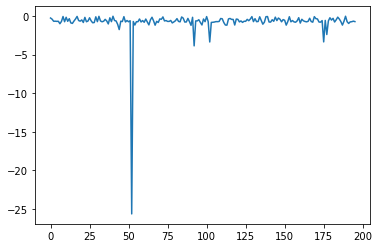

In [7]:
plt.plot(target_list)

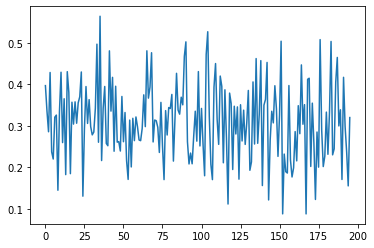

In [8]:
plt.plot(X_MAE_list)

In [9]:
np.mean(X_MAE_list)

0.30923002399145727